In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Project AI4E

/content/drive/My Drive/Project AI4E


In [ ]:
# !nvidia-smi

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import matplotlib.pyplot as plt
import time
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import  ReduceLROnPlateau, EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow import keras
from keras.layers import Input, LSTM, Dense, BatchNormalization
from keras.models import Model, load_model
tf.__version__

'2.3.0'

In [ ]:
# Load the data
lines = open('movie_lines.txt', encoding='utf-8', errors='ignore').read().split('\n')
conv_lines = open('movie_conversations.txt', encoding='utf-8', errors='ignore').read().split('\n')

In [ ]:
lines[:10]

['L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!',
 'L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!',
 'L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.',
 'L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?',
 "L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go.",
 'L924 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ Wow',
 "L872 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Okay -- you're gonna need to learn how to lie.",
 'L871 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ No',
 'L870 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I\'m kidding.  You know how sometimes you just become this "persona"?  And you don\'t know how to quit?',
 'L869 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Like my fear of wearing pastels?']

In [ ]:
conv_lines[:10]

["u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L194', 'L195', 'L196', 'L197']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L198', 'L199']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L200', 'L201', 'L202', 'L203']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L204', 'L205', 'L206']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L207', 'L208']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L271', 'L272', 'L273', 'L274', 'L275']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L276', 'L277']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L280', 'L281']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L363', 'L364']",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L365', 'L366']"]

In [ ]:
# Create a dictionary to map each line's id with its text
id2line = {}
for line in lines:
    _line = line.split(' +++$+++ ')
    if len(_line) == 5:
        id2line[_line[0]] = _line[4]

In [ ]:
# Create a list of all of the conversations' lines' ids.
convs = [ ]
for line in conv_lines[:-1]:
    _line = line.split(' +++$+++ ')[-1][1:-1].replace("'","").replace(" ","")
    convs.append(_line.split(','))

In [ ]:
convs[:10]

[['L194', 'L195', 'L196', 'L197'],
 ['L198', 'L199'],
 ['L200', 'L201', 'L202', 'L203'],
 ['L204', 'L205', 'L206'],
 ['L207', 'L208'],
 ['L271', 'L272', 'L273', 'L274', 'L275'],
 ['L276', 'L277'],
 ['L280', 'L281'],
 ['L363', 'L364'],
 ['L365', 'L366']]

In [ ]:
questions = []
answers = []

for conv in convs:
    for i in range(len(conv)-1):
        questions.append(id2line[conv[i]])
        answers.append(id2line[conv[i+1]])

In [ ]:
limit = 0
for i in range(limit, limit+5):
    print(questions[i])
    print(answers[i])
    print()

Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.
Well, I thought we'd start with pronunciation, if that's okay with you.

Well, I thought we'd start with pronunciation, if that's okay with you.
Not the hacking and gagging and spitting part.  Please.

Not the hacking and gagging and spitting part.  Please.
Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?

You're asking me out.  That's so cute. What's your name again?
Forget it.

No, no, it's my fault -- we didn't have a proper introduction ---
Cameron.



In [ ]:
# Compare lengths of questions and answers
print(len(questions))
print(len(answers))

221616
221616


In [ ]:
def clean_text(text):
    '''Clean text by removing unnecessary characters and altering the format of words.'''

    text = text.lower()
    
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"[0123456789]", "", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"  ", " ", text)
    text = re.sub(r"[-()\"#&/@;:<>{}`+=~|.!?,]", "", text)
    text = re.sub(r"[[]", " ", text)
    text = re.sub(r"[]]", " ", text)
    
    return text

In [ ]:
# Clean the data
clean_questions = []
for question in questions:
    clean_questions.append(clean_text(question))
    
clean_answers = []    
for answer in answers:
    clean_answers.append(clean_text(answer))

In [ ]:
# Take a look at some of the data to ensure that it has been cleaned well.
limit = 0
for i in range(limit, limit+5):
    print(clean_questions[i])
    print(clean_answers[i])
    print()

can we make this quick roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad again
well i thought we would start with pronunciation if that is okay with you

well i thought we would start with pronunciation if that is okay with you
not the hacking and gagging and spitting part please

not the hacking and gagging and spitting part please
okay then how about we try out some french cuisine saturday night

you are asking me out that is so cute that is your name again
forget it

no no it is my fault  we did not have a proper introduction 
cameron



In [ ]:
# Find the length of sentences
lengths = []
for question in clean_questions:
    lengths.append(len(question.split()))
for answer in clean_answers:
    lengths.append(len(answer.split()))

# Create a dataframe so that the values can be inspected
lengths = pd.DataFrame(lengths, columns=['counts'])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[]

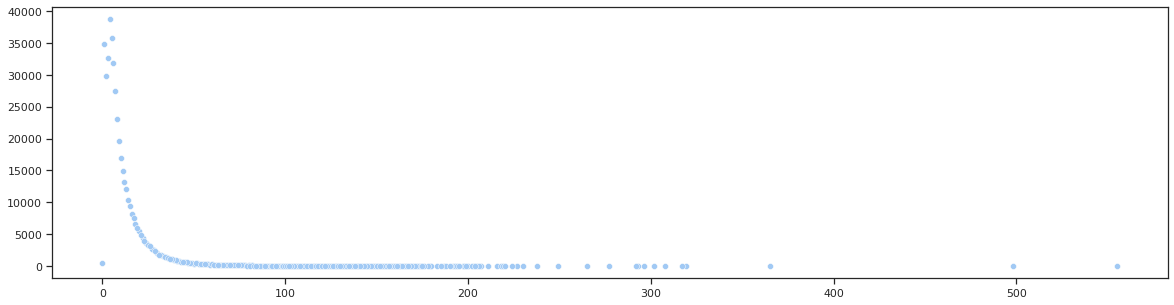

In [ ]:
from collections import Counter
ok = Counter(lengths['counts'])
ok = dict(ok)
x = []
y =[]
for k, v in ok.items():
  x.append(k)
  y.append(v)
plt.figure(figsize=(20,5))
sns.scatterplot(x,y)
plt.plot()

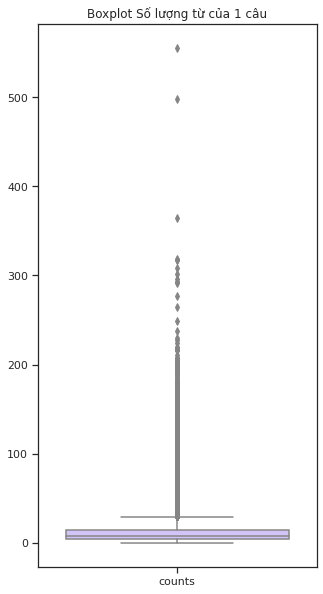

In [ ]:
plt.figure(figsize=(5,10))
plt.title('Boxplot Số lượng từ của 1 câu')
sns.boxplot( palette=["m", "g"],
            data=lengths)
plt.show()

In [ ]:
print(lengths.describe())


              counts
count  443232.000000
mean       10.861871
std        12.200338
min         0.000000
25%         4.000000
50%         7.000000
75%        14.000000
max       555.000000


==> Dữ liệu tập trung nhiều ở câu có số lượng 3 - 6 từ / 1 câu 

---





** Do tensor tạo bằng pandas có giới hạn nên trong bài chọn số từ 2 - 4 để train 

In [ ]:
# dùng searbon để in dữ liệu ra ngoài theo 3 khoảng  


In [ ]:
shorter = 0;
longer = 0;
between = 0
size = lengths.size
for i in range(size):
  if ( lengths['counts'][i] >= 2  and lengths['counts'][i] <= 4):
    between+=1
  elif lengths['counts'][i] < 2 :
    shorter+=1
  elif lengths['counts'][i] > 4:
    longer+=1




[]

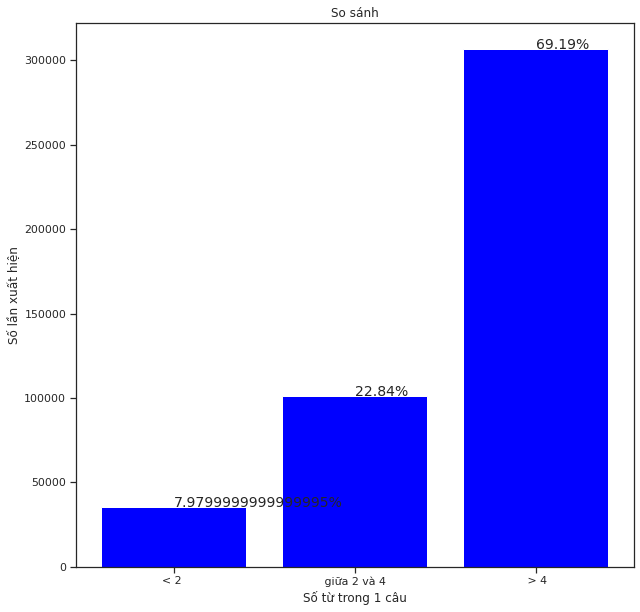

In [ ]:
ten_cot = ["< 2 ", " giữa 2 và 4 ", " > 4"]
gia_tri = [shorter, between, longer]

z1 = format(round(shorter/(shorter+between+longer),4)*100) + '%'
z2 = format(round(between/(shorter+between+longer),4)*100) + '%'
z3 = format(round(longer/(shorter+between+longer),4)*100) + '%'
data_labels = [z1,z2,z3]
plt.figure(figsize=(10,10))
plt.bar(ten_cot, gia_tri, color  = 'blue')

for i in range(len(gia_tri)): # your number of bars
  plt.text(x = ten_cot[i], #takes your x values as horizontal positioning argument 
  y = gia_tri[i]+10, #takes your y values as vertical positioning argument 
  s = data_labels[i], # the labels you want to add to the data
  size = 14)
plt.title("So sánh")
plt.xlabel("Số từ trong 1 câu")
plt.ylabel("Số lần xuất hiện")
plt.plot()

In [ ]:
# Remove questions and answers that are shorter than 2 words and longer than 20 words.
min_line_length = 2
max_line_length = 4

# Filter out the questions that are too short/long
short_questions_temp = []
short_answers_temp = []

i = 0
for question in clean_questions:
    if len(question.split()) >= min_line_length and len(question.split()) <= max_line_length:
        short_questions_temp.append(question)
        short_answers_temp.append(clean_answers[i])
    i += 1

# Filter out the answers that are too short/long
short_questions = []
short_answers = []

i = 0
for answer in short_answers_temp:
    if len(answer.split()) >= min_line_length and len(answer.split()) <= max_line_length:
        short_answers.append(answer)
        short_questions.append(short_questions_temp[i])
    i += 1

Số từ của câu hỏi ban đầu:  221616
Số từ câu trả lời ban đầu:  221616
Số từ của câu hỏi sau này:  12684
Số từ của câu hỏi sau này:  12684
% of data used: 5.72% 


[]

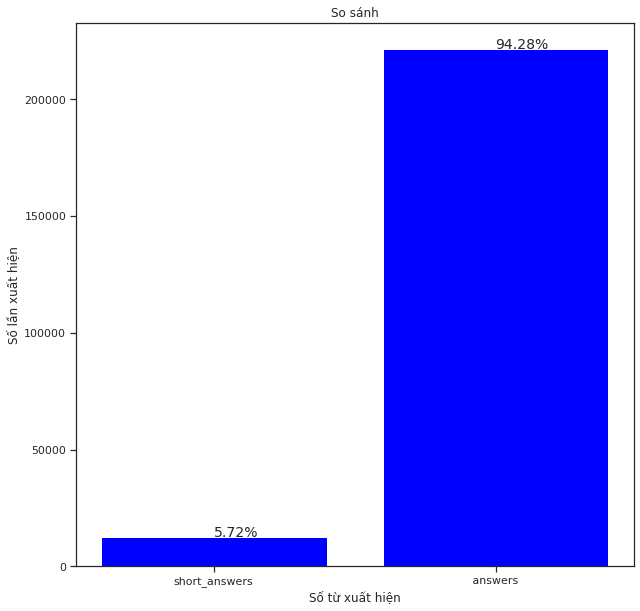

In [ ]:
# Compare the number of lines we will use with the total number of lines.
y1 = len(short_answers)
y2 = len(answers)
z1 = format(round(len(short_questions)/len(questions),4)*100) + '%'
z2 = format(round(1- len(short_questions)/len(questions),4)*100) + '%'
data_labels = [z1,z2]
print("Số từ của câu hỏi ban đầu: ", len(questions))
print("Số từ câu trả lời ban đầu: ", len(answers)) 
print("Số từ của câu hỏi sau này: ", len(short_questions))
print("Số từ của câu hỏi sau này: ", len(short_answers))
print("% of data used: {}% ".format(round(len(short_questions)/len(questions),4)*100))
ten_cot = ["short_answers", " answers "]
gia_tri = [y1,y2]
plt.figure(figsize=(10,10))
plt.bar(ten_cot, gia_tri, color  = 'blue')
for i in range(len(gia_tri)): # your number of bars
  plt.text(x = ten_cot[i], #takes your x values as horizontal positioning argument 
  y = gia_tri[i]+1, #takes your y values as vertical positioning argument 
  s = data_labels[i], # the labels you want to add to the data
  size = 14)
plt.title("So sánh")
plt.xlabel("Số từ xuất hiện")
plt.ylabel("Số lần xuất hiện")
plt.plot()


==> Do mình chỉ lấy số từ của câu trả lời và câu hỏi chỉ là 2 đến 4 cho nên số lượng từ phổ biến được sử dụng là rất ít

In [ ]:
min_line_length = 2
max_line_length = 4

short_questions_temp = []
short_answers_temp = []

i = 0
for question in clean_questions:
    if len(question.split()) >= min_line_length and len(question.split()) <= max_line_length:
        short_questions_temp.append(question)
        short_answers_temp.append(clean_answers[i])
    i += 1

short_questions = []
short_answers = []

i = 0
for answer in short_answers_temp:
    if len(answer.split()) >= min_line_length and len(answer.split()) <= max_line_length:
        short_answers.append(answer)
        short_questions.append(short_questions_temp[i])
    i += 1

In [ ]:
vocab = {}
for question in short_questions:
    for word in question.split():
        if word not in vocab:
            vocab[word] = 1
        else:
            vocab[word] += 1
            
for answer in short_answers:
    for word in answer.split():
        if word not in vocab:
            vocab[word] = 1
        else:
            vocab[word] += 1

In [ ]:
# Remove rare words from the vocabulary.
# We will aim to replace fewer than 5% of words with <UNK>
# You will see this ratio soon.
threshold = 1
count = 0
for k,v in vocab.items():
    if v >= threshold:
        count += 1

In [ ]:
print("Size of total vocab:", len(vocab))
print("Size of vocab we will use:", count)

Size of total vocab: 7742
Size of vocab we will use: 7742


In [ ]:
# In case we want to use a different vocabulary sizes for the source and target text, 
# we can set different threshold values.
# Nonetheless, we will create dictionaries to provide a unique integer for each word.
questions_vocab_to_int = {}

word_num = 0
for word, count in vocab.items():
    if count >= threshold:
        questions_vocab_to_int[word] = word_num
        word_num += 1

answers_vocab_to_int = {}

word_num = 0
for word, count in vocab.items():
    if count >= threshold:
        answers_vocab_to_int[word] = word_num
        word_num += 1

In [ ]:
# Add the unique tokens to the vocabulary dictionaries.
codes = ['<END>','<UNK>','<START>']
for code in codes:
    questions_vocab_to_int[code] = len(questions_vocab_to_int)+1
for code in codes:
    answers_vocab_to_int[code] = len(answers_vocab_to_int)+1

In [ ]:
questions_int_to_vocab = {v_i: v for v, v_i in questions_vocab_to_int.items()}
answers_int_to_vocab = {v_i: v for v, v_i in answers_vocab_to_int.items()}

In [ ]:
# Check the length of the dictionaries.
print(len(questions_vocab_to_int))
print(len(questions_int_to_vocab))
print(len(answers_vocab_to_int))
print(len(answers_int_to_vocab))

7745
7745
7745
7745


In [ ]:
# Add the end of sentence token to the end of every answer.
for i in range(len(short_answers)):
    short_answers[i] = '<START> ' +short_answers[i] + ' <END>'

In [ ]:
# Convert the text to integers. 
# Replace any words that are not in the respective vocabulary with <UNK> 
questions_int = []
for question in short_questions:
    ints = []
    for word in question.split():
        if word not in questions_vocab_to_int:
            ints.append(questions_vocab_to_int['<UNK>'])
        else:
            ints.append(questions_vocab_to_int[word])
    questions_int.append(ints)
    
answers_int = []
for answer in short_answers:
    ints = []
    for word in answer.split():
        if word not in answers_vocab_to_int:
            ints.append(answers_vocab_to_int['<UNK>'])
        else:
            ints.append(answers_vocab_to_int[word])
    answers_int.append(ints)

In [ ]:
# Check the lengths
print(len(questions_int))
print(len(answers_int))

12684
12684


In [ ]:
word_count = 0
unk_count = 0

for question in questions_int:
    for word in question:
        if word == questions_vocab_to_int["<UNK>"]:
            unk_count += 1
        word_count += 1
    
for answer in answers_int:
    for word in answer:
        if word == answers_vocab_to_int["<UNK>"]:
            unk_count += 1
        word_count += 1
    
unk_ratio = round(unk_count/word_count,4)*100
print("Total number of words:", word_count)
print("Number of times <UNK> is used:", unk_count)
print("Percent of words that are <UNK>: {}%".format(round(unk_ratio,3)))

Total number of words: 103515
Number of times <UNK> is used: 0
Percent of words that are <UNK>: 0.0%


In [ ]:
# Sort questions and answers by the length of questions.
# This will reduce the amount of padding during training
# Which should speed up training and help to reduce the loss

sorted_questions = []
sorted_answers = []

for length in range(1, max_line_length+1):
    for i in enumerate(questions_int):
        if len(i[1]) == length:
            sorted_questions.append(questions_int[i[0]])
            sorted_answers.append(answers_int[i[0]])

print(len(sorted_questions))
print(len(sorted_answers))

12684
12684


In [ ]:
input_docs = short_questions
target_docs = short_answers
input_features_dict = questions_vocab_to_int
target_features_dict = answers_vocab_to_int
reverse_target_features_dict = answers_int_to_vocab

In [ ]:
max_encoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", input_doc)) for input_doc in input_docs])
max_decoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", target_doc)) for target_doc in target_docs])

In [ ]:
encoder_input_data = np.zeros(
    (len(sorted_questions), max_encoder_seq_length, len(questions_vocab_to_int) + 1),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(sorted_questions), max_decoder_seq_length, len(answers_vocab_to_int) + 1),
    dtype='float32'
)
decoder_target_data = np.zeros(
    (len(sorted_questions), max_decoder_seq_length, len(answers_vocab_to_int) + 1),
    dtype='float32'
)

In [ ]:
for line, (input_doc, target_doc) in enumerate(zip(input_docs, target_docs)):
    for timestep, token in enumerate(re.findall(r"[\w']+|[^\s\w]", input_doc)):
        encoder_input_data[line, timestep, input_features_dict[token]] = 1.
    
    for timestep, token in enumerate(target_doc.split()):
        decoder_input_data[line, timestep, target_features_dict[token]] = 1.
        if timestep > 0:
            decoder_target_data[line, timestep - 1, target_features_dict[token]] = 1.

In [ ]:
num_encoder_tokens = len(questions_vocab_to_int) + 1
num_decoder_tokens = len(questions_vocab_to_int) + 1

In [ ]:
def lr_shedule(epoch):
  lr = 0.01
  if epoch > 70:
    return 0.001
  elif epoch > 50:
    return 0.005
  elif epoch > 20:
    return 0.008
  return lr 

In [ ]:
lr_callback= LearningRateScheduler(lr_shedule)
early_callback = EarlyStopping(patience=5)
model_checkpont_callback= ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=3, min_lr=0.001)
checkpointer = ModelCheckpoint(filepath="/content/drive/My Drive/Project AI4E/weights.hdf5",monitor = 'accuracy' ,verbose=1, save_best_only=True)
callbacks = [lr_callback,model_checkpont_callback ]

In [ ]:
# #Dimensionality
dimensionality = 256
#The batch size and number of epochs
batch_size = 20
epochs = 100
# #Encoder
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder_lstm = LSTM(dimensionality, return_state=True)
encoder_outputs, state_hidden, state_cell = encoder_lstm(encoder_inputs)
encoder_states = [state_hidden, state_cell]
# #Decoder
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(dimensionality, return_sequences=True, return_state=True)
decoder_outputs, decoder_state_hidden, decoder_state_cell = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
#Model
training_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
#Compiling
training_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], sample_weight_mode='temporal')
training_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 7746)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 7746)] 0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 8195072     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  8195072     input_2[0][0]                    
                                                                 lstm[0][1]            

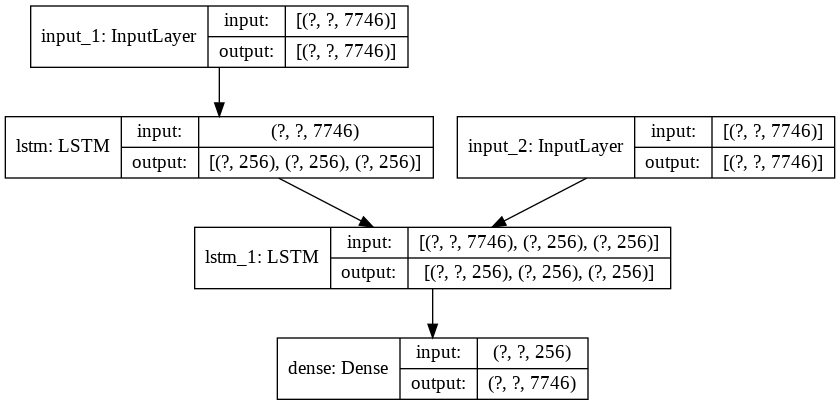

In [ ]:
plot_model(training_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
training_model.fit([encoder_input_data, decoder_input_data], 
                   decoder_target_data, 
                   batch_size = batch_size, 
                   epochs = epochs,
                   callbacks = callbacks)

Epoch 1/100
635/635 [==============================] - 13s 20ms/step - loss: 1.6596 - accuracy: 0.1047
Epoch 2/100
635/635 [==============================] - 13s 20ms/step - loss: 1.4008 - accuracy: 0.1184
Epoch 3/100
635/635 [==============================] - 13s 20ms/step - loss: 1.3011 - accuracy: 0.1226
Epoch 4/100
635/635 [==============================] - 13s 21ms/step - loss: 1.1395 - accuracy: 0.1337
Epoch 5/100
635/635 [==============================] - 13s 21ms/step - loss: 1.0123 - accuracy: 0.1487
Epoch 6/100
635/635 [==============================] - 13s 21ms/step - loss: 0.9263 - accuracy: 0.1589
Epoch 7/100
635/635 [==============================] - 13s 21ms/step - loss: 0.8588 - accuracy: 0.1683
Epoch 8/100
635/635 [==============================] - 13s 21ms/step - loss: 0.8046 - accuracy: 0.1761
Epoch 9/100
635/635 [==============================] - 13s 21ms/step - loss: 0.7379 - accuracy: 0.1859
Epoch 10/100
635/635 [==============================] - 13s 21ms/step - l

In [ ]:
encoder_inputs = training_model.input[0]
encoder_outputs, state_h_enc, state_c_enc = training_model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

In [ ]:
latent_dim = 256
decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]

In [ ]:
decoder_outputs, state_hidden, state_cell = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [ ]:
def decode_response(test_input):
    #Getting the output states to pass into the decoder
    states_value = encoder_model.predict(test_input)
    #Generating empty target sequence of length 1
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    #Setting the first token of target sequence with the start token
    target_seq[0, 0, target_features_dict['<START>']] = 1.
    #A variable to store our response word by word
    decoded_sentence = ''
    
    stop_condition = False
    while not stop_condition:
      #Predicting output tokens with probabilities and states
      output_tokens, hidden_state, cell_state = decoder_model.predict([target_seq] + states_value)
#Choosing the one with highest probability
      sampled_token_index = np.argmax(output_tokens[0, -1, :])
      sampled_token = reverse_target_features_dict[sampled_token_index]
      decoded_sentence += " " + sampled_token
#Stop if hit max length or found the stop token
      if (sampled_token == '<EOS>' or len(decoded_sentence) > 10):
        stop_condition = True
#Update the target sequence
      target_seq = np.zeros((1, 1, num_decoder_tokens))
      target_seq[0, 0, sampled_token_index] = 1.
      #Update states
      states_value = [hidden_state, cell_state]
    return decoded_sentence

In [ ]:
class ChatBot:
  negative_responses = ("no", "nope", "nah", "naw", "not a chance", "sorry")
  exit_commands = ("quit", "pause", "exit", "goodbye", "bye", "later", "stop")
#Method to start the conversation
  def start_chat(self):
    user_response = input("Hi, I'm a chatbot trained on random dialogs. Would you like to chat with me?\n")
    # print("Human: " + user_response)
    # print("\n")
    if user_response in self.negative_responses:
      print("Ok, have a great day!")
      return
    self.chat(user_response)
#Method to handle the conversation
  def chat(self, reply):
    while not self.make_exit(reply):
      reply = input(self.generate_response(reply)+"\n")
    
  #Method to convert user input into a matrix
  def string_to_matrix(self, user_input):
    tokens = re.findall(r"[\w']+|[^\s\w]", user_input)
    user_input_matrix = np.zeros(
      (1, max_encoder_seq_length, num_encoder_tokens),
      dtype='float32')
    for timestep, token in enumerate(tokens):
      if token in input_features_dict:
        user_input_matrix[0, timestep, input_features_dict[token]] = 1.
    return user_input_matrix
  
  #Method that will create a response using seq2seq model we built
  def generate_response(self, user_input):
    input_matrix = self.string_to_matrix(user_input)
    chatbot_response = decode_response(input_matrix)
    #Remove <START> and <END> tokens from chatbot_response
    chatbot_response = chatbot_response.replace("<START>",'')
    chatbot_response = chatbot_response.replace("<END>",'')
    return chatbot_response
#Method to check for exit commands
  def make_exit(self, reply):
    for exit_command in self.exit_commands:
      if exit_command in reply:
        print("Ok, have a great day!")
        return True
    return False

In [ ]:
chatbot = ChatBot()
chatbot.start_chat()

Hi, I'm a chatbot trained on random dialogs. Would you like to chat with me?
hi
 hi princess
what do you do
 i am in construction
how are you
 i got fired
how old are you
 nineteen or
have you got a girl friend
 excuse me 
have you got a girlfriend
